In [1]:
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
def load_data(noise_u, noise_f):
    data = sio.loadmat("../dataset/Fisher.mat")
    x_u_train, t_u_train = data["x_u_train"], data["t_u_train"]
    x_f_train, t_f_train = data["x_f_train"], data["t_f_train"]
    x_test, t_test, u_test = data["x_test"], data["t_test"], data["u_test"]
    x_test, t_test, u_test = (
        x_test.reshape([-1, 1]),
        t_test.reshape([-1, 1]),
        u_test.reshape([-1, 1]),
    )
    u_train, f_train = data["u_train"], data["f_train"]
    train_u = x_u_train, t_u_train, u_train
    train_f = x_f_train, t_f_train, f_train
    test = x_test, t_test, u_test
    return train_u, train_f, test

In [3]:
def pde_fn(x, u, r):
    d = 1
    
    u_x, u_t = tf.split(tf.gradients(u, x)[0], 2, axis=-1)
    u_xx = tf.gradients(u_x, x)[0][..., 0:1]
    
    f = u_t - r * u * (1 - u) - d * u_xx
    #f = u_t - r * u_xx
    
    return f

In [4]:
@neuq.utils.timer
def Samplable(
    x_u_train, t_u_train, u_train, x_f_train, t_f_train, f_train, noise, layers
):
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        prior=neuq_vars.fnn.Samplable(layers=layers, mean=0, sigma=1),
    )
    process_logk_1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=1, sigma=1),
    )
    
    # build likelihood
    likelihood_u = neuq.likelihoods.Normal(
        inputs=np.concatenate([x_u_train, t_u_train], axis=-1),
        targets=u_train,
        processes=[process_u],
        sigma=noise,
    )
    likelihood_f = neuq.likelihoods.Normal(
        inputs=np.concatenate([x_f_train, t_f_train], axis=-1),
        targets=f_train,
        processes=[process_u, process_logk_1],
        pde=pde_fn,
        sigma=noise,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_logk_1],
        likelihoods=[likelihood_u, likelihood_f],
    )
    # assign and compile method
    # Change the parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(
        num_samples=500,
        num_burnin=3000,
        init_time_step=0.01,
        leapfrog_step=50,
        seed=66,
    )
    model.compile(method)
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: %.3f \n"%(np.mean(results)))

    processes = [process_u, process_logk_1]
    return processes, samples, model


In [5]:
@neuq.utils.timer
def Trainable(
    x_u_train, t_u_train, u_train, x_f_train, t_f_train, f_train, noise, layers
):
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        posterior=neuq_vars.fnn.Trainable(layers=layers),
    )
    process_logk_1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=1),
    )
    
    loss_u = neuq.likelihoods.MSE(
        inputs=np.concatenate([x_u_train, t_u_train], axis=-1),
        targets=u_train,
        processes=[process_u],
        multiplier=1.0,
    )
    loss_f = neuq.likelihoods.MSE(
        inputs=np.concatenate([x_f_train, t_f_train], axis=-1),
        targets=f_train,
        processes=[process_u, process_logk_1],
        pde=pde_fn,
        multiplier=1.0,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_logk_1],
        likelihoods=[loss_u, loss_f],
    )
    # assign and compile method
    method = neuq.inferences.DEns(
        num_samples=20, num_iterations=20000, optimizer=tf.train.AdamOptimizer(1e-3),
    )
    model.compile(method)
    # obtain posterior samples
    samples = model.run()
    samples = neuq.utils.batch_samples(samples)  # reshape

    processes = [process_u, process_logk_1]
    return processes, samples, model

In [6]:
def plots(
    logk_1_pred,
    u_pred,
    x_test,
    t_test,
    u_test,
    x_u_train,
    t_u_train,
    u_train,
):
    ### DA CAPIRE LA STORIA DEL PERCHè PRENDE L'ESPONENZIALE DELLE VARIABILI
    
    #k_1_pred = np.exp(logk_1_pred)
    k_1_pred = logk_1_pred
    print("Mean & Std of k1 are %.3f, %.3f" % (np.mean(k_1_pred), np.std(k_1_pred)))
    
    u_pred = np.reshape(u_pred, [-1, NT, NX])
    mu = np.mean(u_pred, axis=0)
    std = np.std(u_pred, axis=0)
    
    x_test = np.reshape(x_test, [NT, NX])
    t_test = np.reshape(t_test, [NT, NX])
    u_test = np.reshape(u_test, [NT, NX])
    
    # cambiare i per avere plot su altri istanti di tempo
    i = 0
    
    current_t = t_test[i][0]
    # current_x*10 PERCHè PRIMA LA X è STATA NORMALIZZATA
    current_x = x_u_train[t_u_train == current_t]
    current_u = u_train[t_u_train == current_t]
    # std = np.sqrt(std**2 + 0.1**2)
    plt.plot(np.linspace(0, 3, NX), mu[i, :], "--", label="mean")
    plt.fill_between(
        np.linspace(0, 3, NX), (mu + 2 * std)[i, :], (mu - 2 * std)[i, :], alpha=0.3
    )
    plt.plot(np.linspace(0, 3, NX), u_test[i, :], label="reference")
    plt.plot(current_x, current_u, "o", label="observations")
    plt.legend()
    plt.title("t=" + str(current_t))
    plt.show()

In [8]:
NT, NX = 60, 300
noise = 0.1
train_u, train_f, test = load_data(noise, noise)
x_u_train, t_u_train, u_train = train_u
x_f_train, t_f_train, f_train = train_f
x_test, t_test, u_test = test

layers = [2, 50, 50, 1]

In [8]:
processes, samples, model = Samplable(x_u_train, t_u_train, u_train, x_f_train, t_f_train, f_train, noise, layers,)

#processes, samples, model = Trainable(x_u_train, t_u_train, u_train, x_f_train, t_f_train, f_train, noise, layers,)

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.144 

Execution time for 'Samplable' function is: 466.486 s, 7.775 mins


Mean & Std of k1 are -1.579, 0.030


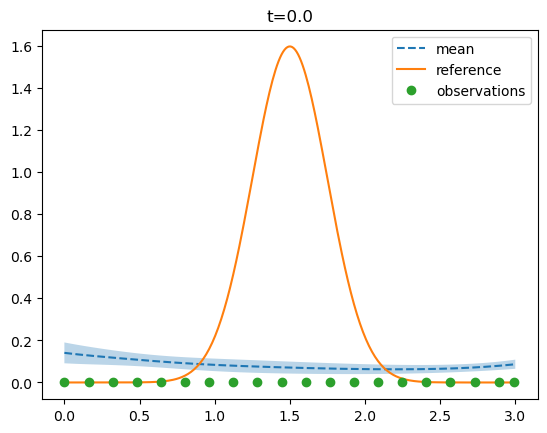

In [9]:
u_pred, logk_1_pred = model.predict(np.concatenate([x_test, t_test], axis=-1), samples, processes, pde_fn=None,)

plots(
    logk_1_pred,
    u_pred,
    x_test,
    t_test,
    u_test,
    x_u_train,
    t_u_train,
    u_train,
)

In [ ]:
#processes, samples, model = Samplable(x_u_train, t_u_train, u_train, x_f_train, t_f_train, f_train, noise, layers,)

processes, samples, model = Trainable(x_u_train, t_u_train, u_train, x_f_train, t_f_train, f_train, noise, layers,)

Supporting backend tensorflow.compat.v1

Compiling a Ensemble method

Generating 0th sample by deep ensemble...
Iteration:  0 , loss:  0.066235766
Iteration:  100 , loss:  0.03859888
Iteration:  200 , loss:  0.036128078
Iteration:  300 , loss:  0.03235684
Iteration:  400 , loss:  0.02865601
Iteration:  500 , loss:  0.026626214
Iteration:  600 , loss:  0.025195198
Iteration:  700 , loss:  0.023881834
Iteration:  800 , loss:  0.022728989
Iteration:  900 , loss:  0.021261942
Iteration:  1000 , loss:  0.020288724
Iteration:  1100 , loss:  0.019437147
Iteration:  1200 , loss:  0.01867753
Iteration:  1300 , loss:  0.017960941
Iteration:  1400 , loss:  0.01729114
Iteration:  1500 , loss:  0.016637586
Iteration:  1600 , loss:  0.01602023
Iteration:  1700 , loss:  0.0154639045
Iteration:  1800 , loss:  0.014996538
Iteration:  1900 , loss:  0.01454929
Iteration:  2000 , loss:  0.014120467
Iteration:  2100 , loss:  0.013635539
Iteration:  2200 , loss:  0.015804136
Iteration:  2300 , loss:  0.0125

Iteration:  900 , loss:  0.020642255
Iteration:  1000 , loss:  0.019433914
Iteration:  1100 , loss:  0.018499948
Iteration:  1200 , loss:  0.017902855
Iteration:  1300 , loss:  0.01670367
Iteration:  1400 , loss:  0.015863078
Iteration:  1500 , loss:  0.015045667
Iteration:  1600 , loss:  0.014283802
Iteration:  1700 , loss:  0.013690218
Iteration:  1800 , loss:  0.012917433
Iteration:  1900 , loss:  0.012318909
Iteration:  2000 , loss:  0.011754541
Iteration:  2100 , loss:  0.011309325
Iteration:  2200 , loss:  0.010912873
Iteration:  2300 , loss:  0.010886538
Iteration:  2400 , loss:  0.010226715
Iteration:  2500 , loss:  0.009929646
Iteration:  2600 , loss:  0.009675035
Iteration:  2700 , loss:  0.009437968
Iteration:  2800 , loss:  0.009447981
Iteration:  2900 , loss:  0.009039122
Iteration:  3000 , loss:  0.008869734
Iteration:  3100 , loss:  0.008730163
Iteration:  3200 , loss:  0.00860187
Iteration:  3300 , loss:  0.008489998
Iteration:  3400 , loss:  0.008390636
Iteration:  350

Iteration:  2100 , loss:  0.013415412
Iteration:  2200 , loss:  0.0128239505
Iteration:  2300 , loss:  0.012314697
Iteration:  2400 , loss:  0.011983359
Iteration:  2500 , loss:  0.01149106
Iteration:  2600 , loss:  0.011141497
Iteration:  2700 , loss:  0.010847238
Iteration:  2800 , loss:  0.010581897
Iteration:  2900 , loss:  0.010383137
Iteration:  3000 , loss:  0.010156252
Iteration:  3100 , loss:  0.009974578
Iteration:  3200 , loss:  0.0098205935
Iteration:  3300 , loss:  0.009669026
Iteration:  3400 , loss:  0.009597737
Iteration:  3500 , loss:  0.009382175
Iteration:  3600 , loss:  0.009240609
Iteration:  3700 , loss:  0.009110476
Iteration:  3800 , loss:  0.008977193
Iteration:  3900 , loss:  0.009788095
Iteration:  4000 , loss:  0.008738706
Iteration:  4100 , loss:  0.008630295
Iteration:  4200 , loss:  0.008538619
Iteration:  4300 , loss:  0.008452809
Iteration:  4400 , loss:  0.008372318
Iteration:  4500 , loss:  0.008302898
Iteration:  4600 , loss:  0.008234231
Iteration: 

Iteration:  3200 , loss:  0.024607513
Iteration:  3300 , loss:  0.0241514
Iteration:  3400 , loss:  0.023667295
Iteration:  3500 , loss:  0.023150112
Iteration:  3600 , loss:  0.022600248
Iteration:  3700 , loss:  0.022033136
Iteration:  3800 , loss:  0.021471381
Iteration:  3900 , loss:  0.020920962
Iteration:  4000 , loss:  0.020365052
Iteration:  4100 , loss:  0.019784417
Iteration:  4200 , loss:  0.019193716
Iteration:  4300 , loss:  0.0186058
Iteration:  4400 , loss:  0.017995289
Iteration:  4500 , loss:  0.017355546
Iteration:  4600 , loss:  0.016714588
Iteration:  4700 , loss:  0.016138874
Iteration:  4800 , loss:  0.01561006
Iteration:  4900 , loss:  0.015126519
Iteration:  5000 , loss:  0.014630725
Iteration:  5100 , loss:  0.0141686
Iteration:  5200 , loss:  0.013730163
Iteration:  5300 , loss:  0.013268841
Iteration:  5400 , loss:  0.012837302
Iteration:  5500 , loss:  0.0124058295
Iteration:  5600 , loss:  0.01198636
Iteration:  5700 , loss:  0.01156713
Iteration:  5800 , l

Iteration:  4500 , loss:  0.008549407
Iteration:  4600 , loss:  0.007902497
Iteration:  4700 , loss:  0.007853885
Iteration:  4800 , loss:  0.0078164
Iteration:  4900 , loss:  0.007778691
Iteration:  5000 , loss:  0.0077455416
Iteration:  5100 , loss:  0.007720046
Iteration:  5200 , loss:  0.007693908
Iteration:  5300 , loss:  0.007688622
Iteration:  5400 , loss:  0.0076522087
Iteration:  5500 , loss:  0.007633062
Iteration:  5600 , loss:  0.0077281725
Iteration:  5700 , loss:  0.0076017566
Iteration:  5800 , loss:  0.007586777
Iteration:  5900 , loss:  0.0076006893
Iteration:  6000 , loss:  0.0075615556
Iteration:  6100 , loss:  0.00754915
Iteration:  6200 , loss:  0.0075601847
Iteration:  6300 , loss:  0.0075277262
Iteration:  6400 , loss:  0.0075168805
Iteration:  6500 , loss:  0.00751488
Iteration:  6600 , loss:  0.0074978755
Iteration:  6700 , loss:  0.0075822724
Iteration:  6800 , loss:  0.0077629937
Iteration:  6900 , loss:  0.007470171
Iteration:  7000 , loss:  0.0074630775
Ite

Iteration:  5600 , loss:  0.00774013
Iteration:  5700 , loss:  0.0077175526
Iteration:  5800 , loss:  0.007740161
Iteration:  5900 , loss:  0.0076817246
Iteration:  6000 , loss:  0.007663492
Iteration:  6100 , loss:  0.007651508
Iteration:  6200 , loss:  0.007635602
Iteration:  6300 , loss:  0.007623052
Iteration:  6400 , loss:  0.0076109017
Iteration:  6500 , loss:  0.0075980355
Iteration:  6600 , loss:  0.008089195
Iteration:  6700 , loss:  0.0075775464
Iteration:  6800 , loss:  0.0075664762
Iteration:  6900 , loss:  0.0075617214
Iteration:  7000 , loss:  0.007548951
Iteration:  7100 , loss:  0.007539044
Iteration:  7200 , loss:  0.0075319754
Iteration:  7300 , loss:  0.0075225015
Iteration:  7400 , loss:  0.0075160256
Iteration:  7500 , loss:  0.0075066388
Iteration:  7600 , loss:  0.0074974094
Iteration:  7700 , loss:  0.007491614
Iteration:  7800 , loss:  0.007481442
Iteration:  7900 , loss:  0.007490571
Iteration:  8000 , loss:  0.0074654557
Iteration:  8100 , loss:  0.0074562468

Iteration:  6700 , loss:  0.007864708
Iteration:  6800 , loss:  0.0078842295
Iteration:  6900 , loss:  0.007821349
Iteration:  7000 , loss:  0.0077992175
Iteration:  7100 , loss:  0.007784484
Iteration:  7200 , loss:  0.0077605625
Iteration:  7300 , loss:  0.007740036
Iteration:  7400 , loss:  0.0077233044
Iteration:  7500 , loss:  0.0077031706
Iteration:  7600 , loss:  0.00774139
Iteration:  7700 , loss:  0.007668244
Iteration:  7800 , loss:  0.0076504815
Iteration:  7900 , loss:  0.0076516997
Iteration:  8000 , loss:  0.0076184813
Iteration:  8100 , loss:  0.0076020123
Iteration:  8200 , loss:  0.0075899577
Iteration:  8300 , loss:  0.007572811
Iteration:  8400 , loss:  0.0075575737
Iteration:  8500 , loss:  0.0075461236
Iteration:  8600 , loss:  0.007530363
Iteration:  8700 , loss:  0.008959784
Iteration:  8800 , loss:  0.007504543
Iteration:  8900 , loss:  0.0074912137
Iteration:  9000 , loss:  0.0074946787
Iteration:  9100 , loss:  0.007466766
Iteration:  9200 , loss:  0.007464499

Iteration:  7800 , loss:  0.007759477
Iteration:  7900 , loss:  0.007746189
Iteration:  8000 , loss:  0.007743393
Iteration:  8100 , loss:  0.0077233757
Iteration:  8200 , loss:  0.008005245
Iteration:  8300 , loss:  0.0077030053
Iteration:  8400 , loss:  0.007692001
Iteration:  8500 , loss:  0.0076813144
Iteration:  8600 , loss:  0.007673712
Iteration:  8700 , loss:  0.007663504
Iteration:  8800 , loss:  0.011036554
Iteration:  8900 , loss:  0.0076473313
Iteration:  9000 , loss:  0.0076386677
Iteration:  9100 , loss:  0.007677875
Iteration:  9200 , loss:  0.0076242182
Iteration:  9300 , loss:  0.0076162103
Iteration:  9400 , loss:  0.008070215
Iteration:  9500 , loss:  0.0076029003
Iteration:  9600 , loss:  0.0075956383
Iteration:  9700 , loss:  0.007959357
Iteration:  9800 , loss:  0.0075830165
Iteration:  9900 , loss:  0.007576041
Iteration:  10000 , loss:  0.0075711533
Iteration:  10100 , loss:  0.0075644185
Iteration:  10200 , loss:  0.008086373
Iteration:  10300 , loss:  0.007553

Iteration:  9000 , loss:  0.0076018414
Iteration:  9100 , loss:  0.0075901304
Iteration:  9200 , loss:  0.008014341
Iteration:  9300 , loss:  0.007570659
Iteration:  9400 , loss:  0.0075598964
Iteration:  9500 , loss:  0.007559271
Iteration:  9600 , loss:  0.00754213
Iteration:  9700 , loss:  0.007549664
Iteration:  9800 , loss:  0.0075251376
Iteration:  9900 , loss:  0.007515703
Iteration:  10000 , loss:  0.0075110956
Iteration:  10100 , loss:  0.0075001456
Iteration:  10200 , loss:  0.007932666
Iteration:  10300 , loss:  0.0074863983
Iteration:  10400 , loss:  0.0074782
Iteration:  10500 , loss:  0.008367691
Iteration:  10600 , loss:  0.0074651306
Iteration:  10700 , loss:  0.007457328
Iteration:  10800 , loss:  0.007475604
Iteration:  10900 , loss:  0.00744458
Iteration:  11000 , loss:  0.0074377977
Iteration:  11100 , loss:  0.0074322387
Iteration:  11200 , loss:  0.007424931
Iteration:  11300 , loss:  0.007444667
Iteration:  11400 , loss:  0.007413161
Iteration:  11500 , loss:  0.

Iteration:  10200 , loss:  0.007575083
Iteration:  10300 , loss:  0.0075680423
Iteration:  10400 , loss:  0.007558303
Iteration:  10500 , loss:  0.0075492626
Iteration:  10600 , loss:  0.0075419405
Iteration:  10700 , loss:  0.007532912
Iteration:  10800 , loss:  0.0076423977
Iteration:  10900 , loss:  0.007517774
Iteration:  11000 , loss:  0.0075092483
Iteration:  11100 , loss:  0.0075100134
Iteration:  11200 , loss:  0.007494929
Iteration:  11300 , loss:  0.009827861
Iteration:  11400 , loss:  0.007480944
Iteration:  11500 , loss:  0.007473096
Iteration:  11600 , loss:  0.0074733775
Iteration:  11700 , loss:  0.0074598617
Iteration:  11800 , loss:  0.007891473
Iteration:  11900 , loss:  0.0074469396
Iteration:  12000 , loss:  0.0074396105
Iteration:  12100 , loss:  0.0074384646
Iteration:  12200 , loss:  0.007427636
Iteration:  12300 , loss:  0.0074217133
Iteration:  12400 , loss:  0.007416726
Iteration:  12500 , loss:  0.0074096867
Iteration:  12600 , loss:  0.0074029625
Iteration: 

In [ ]:
u_pred, logk_1_pred = model.predict(np.concatenate([x_test, t_test], axis=-1), samples, processes, pde_fn=None,)

plots(
    logk_1_pred,
    u_pred,
    x_test,
    t_test,
    u_test,
    x_u_train,
    t_u_train,
    u_train,
)